# Text Classification

Sentiment analysis uses binary classification, it examines a sample of text such as a review and scores it on a scale of 0.0 to 1.0 where values closer to 0.0 are negative and values closer to 1.0 are positive. Since machine learning works with numbers and not text the text has to be converted into numbers, one common approach is to build a table of word frequencies called bag of words.

## Preparing Text for Classification

First the text has to be converted into numbers, this process is known as vectorization. One common techniqe for vectorization is to build a table where each row represents a text sample such as a review, and each column represents a word in the training text. The numbers in the rows are word counts and the final number in each row is a label 0 for negative and 1 for positive. Before text is vectorized it is cleaned, there are several ways to clean text:
1. Converting all characters to lowercase
2. Removing punctuation symbols
3. Removing stop words (common words such as "the" and "and" that have little impact on the outcome)

Once cleaned sentences are divided into individual words (tokenized) and the words are used to produce the table columns. N-grams are combinations of a few or more consecutive words that should be treated as a single word. The idea is that some words might be more meaningful if they appear next to each other in a sentence than if they appear far apart. Without n-grams, the relative proximity of words is ignored.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

lines = [
    'Four score and 7 years ago our fathers brought forth,',
    '... a new NATION, conceived in liberty $$$,',
    'and dedicated to the PrOpOsItIoN that all men are created equal',
    'One nation\'s freedom equals #freedom for another $nation!'
]

vectorizer = CountVectorizer(stop_words='english')
word_matrix = vectorizer.fit_transform(lines)

feature_names = vectorizer.get_feature_names_out()
line_names = [f'Line {(i + 1):d}' for i, _ in enumerate(word_matrix)]

df = pd.DataFrame(data=word_matrix.toarray(), index=line_names, columns=feature_names)
df.head()

,ago,brought,conceived,created,dedicated,equal,equals,fathers,forth,freedom,liberty,men,nation,new,proposition,score,years
Line 1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1
Line 2,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0
Line 3,0,0,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0
Line 4,0,0,0,0,0,0,1,0,0,2,0,0,2,0,0,0,0


Stemming and lemmatizing words are also text preparation techniques where words such as equal and equals get counted as the same word.

To remove numbers from text first create a function that removes numbers and then pass it as a parameter to CountVectorizer.

In [2]:
import re

def preprocess_text(text):
    return re.sub(r'\d+', '', text).lower()

vectorizer = CountVectorizer(stop_words='english', preprocessor=preprocess_text)
word_matrix = vectorizer.fit_transform(lines)

## Sentiment Analysis

In [3]:
df = pd.read_csv('Data/reviews.csv', encoding='ISO-8859-1')
df.head()

,Text,Sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       50000 non-null  object
 1   Sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [5]:
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          25000  24697  Nickelodeon has gone down the toilet. They hav...   
1          25000  24884  Loved today's show!!! It was a variety and not...   

                
          freq  
Sentiment       
0            3  
1            5

The dataset has duplicate rows

In [6]:
df = df.drop_duplicates()
df.groupby('Sentiment').describe()

Text                                                            \
           count unique                                                top   
Sentiment                                                                    
0          24697  24697  This is one of the dumbest films, I've ever se...   
1          24884  24884  Working-class romantic drama from director Mar...   

                
          freq  
Sentiment       
0            1  
1            1

In [7]:
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english', min_df=20)

x = vectorizer.fit_transform(df['Text'])
y = df['Sentiment']

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)

In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=0)
model.fit(x_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


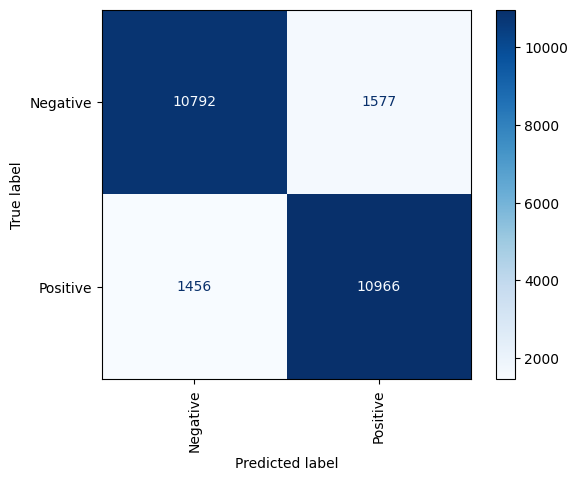

In [10]:
%matplotlib inline
from sklearn.metrics import ConfusionMatrixDisplay as cmd

cmd.from_estimator(model, x_test, y_test, display_labels=['Negative', 'Positive'], cmap='Blues',
                   xticks_rotation='vertical')

## Naive Bayes

Logistic regression is a go-to algorithm for classification models but for text classification the most used algorithm is Naive Bayes. It's a classification algorithm based on the Bayes' theorem which provides a means for calculating conditional probabilities.

Bayes's theorem:

The probability that A is true given that B is true is equal to the probability that B is true given that A is true multiplied by the probability that A is true divided by the probability that B is true.

To translate this into text classification:

Suppose that 10% of all the emails are spam that is P(A). Analysis reveals that 5% of the spam emails contain the word "congratulations" but just 1% of all emails contain the same word. Therfore P(B|A) is 0.05 and P(B) is 0.01. The probability of an email being spam if it contains the word congratulations is P(A|B) which is (0.05 * 0.10)/0.01 or 0.50.

If you make some simple (naive) assumptions like that the order of words in an email doesn't matter and that every word has equal weight you can write Bayes' equation:

P(S|Message) = P(S)*P(word1|S))*P(word2|S))...P(wordn|S)

Or in english:

The probability that a message is spam is proportional to the product of:
1. The probability that any message in the dataset is spam P(S)
2. The probability that each word in the message appears in a spam message, or P(word|S). For a given word P(word|S) is simply the number of times the word appears in spam messages divided by the number of words in all the spam messages.

## Spam Filtering

In [11]:
df = pd.read_csv('Data/ham-spam.csv')
df.head()

,IsSpam,Text
0,0,key issues going forwarda year end reviews rep...
1,0,congrats contratulations the execution the cen...
2,0,key issues going forwardall under control set...
3,0,epmi files protest entergy transcoattached our...
4,0,california power please contact kristin walsh ...


In [12]:
df.groupby('IsSpam').describe()

Text                                                               
       count unique                                                top freq
IsSpam                                                                     
0        500    499   paso firm capacity award memorandumlouise del...    2
1        500    500  unfeigned alilum ciall ambiien aagrra xaanax c...    1

In [13]:
df = df.drop_duplicates()
df.groupby('IsSpam').describe()

Text                                                               
       count unique                                                top freq
IsSpam                                                                     
0        499    499  reminder vacationlouise would like remind you ...    1
1        500    500  unfeigned alilum ciall ambiien aagrra xaanax c...    1

In [14]:
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
x = vectorizer.fit_transform(df['Text'])
y = df['IsSpam']

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [16]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(x_train, y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


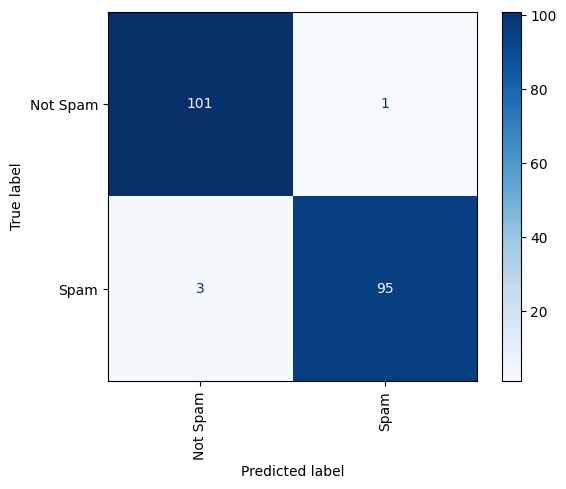

In [17]:
cmd.from_estimator(model, x_test, y_test, display_labels=['Not Spam', 'Spam'], cmap='Blues', xticks_rotation='vertical')

In [18]:
model.score(x_test, y_test)

0.98

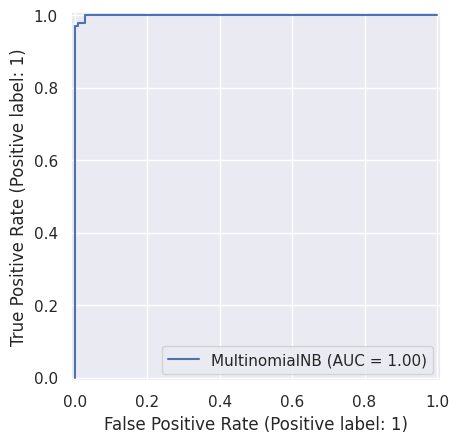

In [19]:
from sklearn.metrics import RocCurveDisplay as rcd
import seaborn as sns
sns.set()

rcd.from_estimator(model, x_test, y_test)

## Recommender Systems

Recommender systems come in many forms:
1. Popularity-based systems: present options to customers based on what products and services are popular at the time
2. Collaborative systems: make recommendations based on what others have selected
3. Content-based systems: require machine learning and these systems quanify similarity between items and make recommendations based on it.

## Cosine Similarity

Cosine similarity is a mathematical means for computing the similarity between pairs of vectors. The basic idea is to take each value in a sample, for example the word counts in a row of vectorized text and use them as endpoints coordinates for a vector. Do that for two samples and then compute the cosine between vectors in m-dimensional space where m is the number of values in each sample. Because the cosine of 0 is 1 two identical vectors have a similarity of 1. 

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

data = [[1,2],[2,3],[3,1]]
cosine_similarity(data)

array([[1.        , 0.99227788, 0.70710678],
       [0.99227788, 1.        , 0.78935222],
       [0.70710678, 0.78935222, 1.        ]])

## Building a Movie Recommendation System

In [21]:
df = pd.read_csv('Data/movies.csv')
df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [22]:
df = df[['title','genres','keywords', 'cast', 'director']]
df = df.fillna('')
df.head()

,title,genres,keywords,cast,director
0,Avatar,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Sam Worthington Zoe Saldana Sigourney Weaver S...,James Cameron
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,Johnny Depp Orlando Bloom Keira Knightley Stel...,Gore Verbinski
2,Spectre,Action Adventure Crime,spy based on novel secret agent sequel mi6,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,Sam Mendes
3,The Dark Knight Rises,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,Christian Bale Michael Caine Gary Oldman Anne ...,Christopher Nolan
4,John Carter,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,Taylor Kitsch Lynn Collins Samantha Morton Wil...,Andrew Stanton


In [24]:
df['features'] = df['title'] + ' ' + df['genres'] + ' ' + df['keywords'] + ' ' + df['cast'] + ' ' + df['director']
df.head()

,title,genres,keywords,cast,director,features
0,Avatar,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,Sam Worthington Zoe Saldana Sigourney Weaver S...,James Cameron,Avatar Action Adventure Fantasy Science Fictio...
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,Johnny Depp Orlando Bloom Keira Knightley Stel...,Gore Verbinski,Pirates of the Caribbean: At World's End Adven...
2,Spectre,Action Adventure Crime,spy based on novel secret agent sequel mi6,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,Sam Mendes,Spectre Action Adventure Crime spy based on no...
3,The Dark Knight Rises,Action Crime Drama Thriller,dc comics crime fighter terrorist secret ident...,Christian Bale Michael Caine Gary Oldman Anne ...,Christopher Nolan,The Dark Knight Rises Action Crime Drama Thril...
4,John Carter,Action Adventure Science Fiction,based on novel mars medallion space travel pri...,Taylor Kitsch Lynn Collins Samantha Morton Wil...,Andrew Stanton,John Carter Action Adventure Science Fiction b...


In [25]:
vectorizer = CountVectorizer(stop_words='english', min_df=20)
word_matrix = vectorizer.fit_transform(df['features'])
word_matrix.shape

(4803, 918)

In [27]:
sim = cosine_similarity(word_matrix)

In [31]:
def get_recommendations(title, df, sim, count=10):
    index = df.index[df['title'].str.lower() == title.lower()]

    if(len(index) == 0):
        return[]

    similarities = list(enumerate(sim[index[0]]))
    recommendations = sorted(similarities, key=lambda x: x[1], reverse=True)
    top_recs = recommendations[1:count + 1]
    titles = []

    for i in range(len(top_recs)):
        title = df.iloc[top_recs[i][0]]['title']
        titles.append(title)

    return titles

In [32]:
get_recommendations('Skyfall', df, sim)

['Spectre',
 'Quantum of Solace',
 'Johnny English Reborn',
 'Clash of the Titans',
 'Die Another Day',
 'Diamonds Are Forever',
 'Wrath of the Titans',
 'I Spy',
 'Sanctum',
 'Blackthorn']